In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd

In [3]:
data = pd.read_csv('/content/drive/My Drive/solar-forecasting/data/meteo_galicia.csv', sep=';', parse_dates=['fecha'], decimal=',',
                 infer_datetime_format=True, low_memory=False, index_col='fecha').sort_index()

### Cargar datos

In [4]:
#data = pd.read_csv('./data/meteo_galicia.csv', sep=';', parse_dates=['fecha'], decimal=',',
#                 infer_datetime_format=True, low_memory=False, index_col='fecha').sort_index()

In [5]:
data

,estacionid,lat,lon,tamb,hum,pres,prec,rad,vvien,tipodered
fecha,,,,,,,,,,
2019-01-01 00:10:00,20284,42.4044,-8.6730,5.4,0,1022.0,0.0,0.0,0.7,OFICIAL
2019-01-01 00:10:00,20233,42.3554,-7.0086,7.3,0,892.1,0.0,0.0,3.5,OFICIAL
2019-01-01 00:10:00,20218,43.1626,-7.2826,9.2,0,955.0,0.0,0.0,0.0,OFICIAL
2019-01-01 00:10:00,20217,42.7071,-7.0471,8.5,0,882.5,0.0,1.0,6.3,OFICIAL
2019-01-01 00:10:00,20221,43.5407,-7.0830,5.3,0,1027.0,0.0,0.0,2.8,OFICIAL
...,...,...,...,...,...,...,...,...,...,...
2019-06-01 19:40:00,20249,42.2987,-7.5907,25.0,0,909.0,0.0,402.0,2.0,OFICIAL
2019-06-01 19:40:00,20259,42.1630,-7.0896,27.0,0,922.0,0.0,374.0,3.0,OFICIAL
2019-06-01 19:40:00,20255,42.4631,-6.9295,30.0,0,NaN,0.0,378.0,0.0,OFICIAL


In [6]:
data.describe()

,estacionid,lat,lon,tamb,hum,pres,prec,rad,vvien
count,2.510008e+06,2.510008e+06,2.510008e+06,2.507533e+06,2510008.0,1.814653e+06,2.509794e+06,2.499161e+06,2.507539e+06
mean,2.023039e+04,4.266182e+01,-8.022871e+00,8.994252e+00,0.0,9.677706e+02,6.805140e-03,1.167266e+02,2.144441e+00
std,4.163865e+01,4.825840e-01,6.507180e-01,5.504882e+00,0.0,4.522947e+01,2.574166e-01,2.210808e+02,3.068800e+00
min,2.015800e+04,4.189820e+01,-9.178300e+00,-2.800000e+01,0.0,7.000000e+02,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.019500e+04,4.231240e+01,-8.644000e+00,5.000000e+00,0.0,9.430000e+02,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.023100e+04,4.255520e+01,-8.066800e+00,9.000000e+00,0.0,9.750000e+02,0.000000e+00,0.000000e+00,1.000000e+00
75%,2.026600e+04,4.303590e+01,-7.439200e+00,1.200000e+01,0.0,1.004000e+03,0.000000e+00,1.220000e+02,3.000000e+00
max,2.030200e+04,4.373400e+01,-6.765200e+00,4.800000e+01,0.0,1.061000e+03,1.190000e+02,1.265000e+03,1.500000e+02


### Eliminar columnas innecesarias

In [7]:
data = data.drop(columns=['tipodered', 'hum', 'prec', 'vvien', 'pres'])

In [8]:
len(data)

2510008

In [9]:
data.isnull().sum()

estacionid        0
lat               0
lon               0
tamb           2475
rad           10847
dtype: int64

In [10]:
data = data.dropna()

In [11]:
len(data)

2496903

In [12]:
data.isnull().sum()

estacionid    0
lat           0
lon           0
tamb          0
rad           0
dtype: int64

In [13]:
data

,estacionid,lat,lon,tamb,rad
fecha,,,,,
2019-01-01 00:10:00,20284,42.4044,-8.6730,5.4,0.0
2019-01-01 00:10:00,20233,42.3554,-7.0086,7.3,0.0
2019-01-01 00:10:00,20218,43.1626,-7.2826,9.2,0.0
2019-01-01 00:10:00,20217,42.7071,-7.0471,8.5,1.0
2019-01-01 00:10:00,20221,43.5407,-7.0830,5.3,0.0
...,...,...,...,...,...
2019-06-01 19:40:00,20249,42.2987,-7.5907,25.0,402.0
2019-06-01 19:40:00,20259,42.1630,-7.0896,27.0,374.0
2019-06-01 19:40:00,20255,42.4631,-6.9295,30.0,378.0


### Escalar

In [14]:
from sklearn.preprocessing import MinMaxScaler

```python
X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
X_scaled = X_std * (max - min) + min
```

In [15]:
scaler = MinMaxScaler(feature_range=(-1, 1))

In [16]:
scaler.fit(data.drop(columns=['estacionid']))

MinMaxScaler(copy=True, feature_range=(-1, 1))

In [17]:
scaler.data_min_

array([ 41.8982,  -9.1783, -28.    ,   0.    ])

In [18]:
scaler.data_max_

array([  43.734 ,   -6.7652,   43.    , 1265.    ])

### Obtener id de las estaciones

In [19]:
estaciones = [s for s in set(data['estacionid'])]

len(estaciones)

142

### Obtener datos de las estaciones

**Las estaciones que no tienen registro de radiación son eliminadas**

In [20]:
%%time
data_by_station = []

for s in estaciones:
    filter_station = data['estacionid'] == s
    data_station = data[filter_station].drop(columns=['estacionid'])
    d = data_station.describe()
    if d.rad['max'] != 0:
        data_by_station.append(data_station)

CPU times: user 2.45 s, sys: 31.6 ms, total: 2.48 s
Wall time: 2.24 s


In [21]:
len(data_by_station)

111

### Ajustar intervalos de tiempo

**Ajuste de 1 hora**

In [22]:
%%time
data_by_station = [s.resample('1H').mean().ffill().bfill() for s in data_by_station]

CPU times: user 251 ms, sys: 3.94 ms, total: 255 ms
Wall time: 257 ms


In [23]:
data_by_station[0]

,lat,lon,tamb,rad
fecha,,,,
2019-01-01 01:00:00,43.3634,-8.4419,10.700,0.000000
2019-01-01 02:00:00,43.3634,-8.4419,10.350,0.000000
2019-01-01 03:00:00,43.3634,-8.4419,9.800,0.000000
2019-01-01 04:00:00,43.3634,-8.4419,11.125,0.000000
2019-01-01 05:00:00,43.3634,-8.4419,11.675,0.000000
...,...,...,...,...
2019-06-01 15:00:00,43.3634,-8.4419,22.750,851.000000
2019-06-01 16:00:00,43.3634,-8.4419,22.500,800.500000
2019-06-01 17:00:00,43.3634,-8.4419,24.750,693.750000


In [24]:
#for d in data_by_station:
#    d['day']=[x.day for x in d.index]
#    d['month']=[x.month for x in d.index]
#    d['hour']=[x.hour for x in d.index]

In [25]:
# data_by_station[0]

In [26]:
### rad
data_by_station[0].values[:, -1]

array([  0.        ,   0.        ,   0.        , ..., 693.75      ,
       596.5       , 375.66666667])

### Visualización

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize': (16, 6)})

### Preparación de los datos para el entrenamiento de la red

In [28]:
import numpy as np
import tensorflow as tf

# Se fija la semilla para generar valores aleatorios
np.random.seed(1)
tf.random.set_seed(1)

#### Función para preparar los datos para una RNN

In [29]:
def get_rnn_data(dataset, history_size=30, target_size=7):
    start_index = history_size
    end_index = len(dataset) - target_size
    
    data = []
    labels = []
    
    for i in range(start_index, end_index):
        indices = range(i - history_size, i, 1)
        data.append(dataset[indices])
        labels.append(dataset[i:i+target_size, -1])
        
    data = np.array(data)
    labels = np.array(labels)
    
    return data, labels

In [30]:
past_history = 23 # Pasar información de 23 horas anteriores
forecast_horizon = 1 # Obtener nivel de radiacion para la siguiente hora

In [31]:
data_by_station = [scaler.transform(x) for x in data_by_station]

data_by_station[0]

array([[ 0.59625232, -0.38966475,  0.09014085, -1.        ],
       [ 0.59625232, -0.38966475,  0.08028169, -1.        ],
       [ 0.59625232, -0.38966475,  0.06478873, -1.        ],
       ...,
       [ 0.59625232, -0.38966475,  0.48591549,  0.09683794],
       [ 0.59625232, -0.38966475,  0.52816901, -0.056917  ],
       [ 0.59625232, -0.38966475,  0.46478873, -0.40606061]])

In [32]:
%%time
data = [get_rnn_data(d, past_history, forecast_horizon) for d in data_by_station]

CPU times: user 5 s, sys: 27.2 ms, total: 5.03 s
Wall time: 5.03 s


In [33]:
len(data)

111

In [34]:
data_input = data[0][0]
data_target = data[0][1]

In [35]:
data_input.shape

(3619, 23, 4)

In [36]:
data_target.shape

(3619, 1)

In [37]:
%%time
for i in range(1, len(data)):
    data_input = np.concatenate((data_input, data[i][0]))
    data_target = np.concatenate((data_target, data[i][1]))

CPU times: user 4.54 s, sys: 328 ms, total: 4.87 s
Wall time: 4.88 s


In [38]:
data_input.shape

(401335, 23, 4)

In [39]:
rad_range = ['{0}-{1}'.format(i, i+100) for i in range(0, 1100, 100)]

rad_range

['0-100',
 '100-200',
 '200-300',
 '300-400',
 '400-500',
 '500-600',
 '600-700',
 '700-800',
 '800-900',
 '900-1000',
 '1000-1100']

In [40]:
z = np.zeros(shape=(data_target.shape[0], 3))

z2 = np.concatenate((z, data_target), axis=1)

rad = scaler.inverse_transform(z2)[:,-1]

rad.max()

1138.5

In [41]:
rad.min()

0.0

In [42]:
def get_range_category(v):
    if v < 100:
        return 0
    if v < 200:
        return 1
    if v < 300:
        return 2
    if v < 400:
        return 3
    if v < 500:
        return 4
    if v < 600:
        return 5
    if v < 700:
        return 6
    if v < 800:
        return 7
    if v < 900:
        return 8
    if v < 1000:
        return 9
    if v >= 1000:
        return 10

labels = [get_range_category(x) for x in rad]

In [43]:
labels[100:120]

[0, 0, 0, 0, 0, 0, 1, 2, 3, 4, 4, 3, 2, 1, 0, 0, 0, 0, 0, 0]

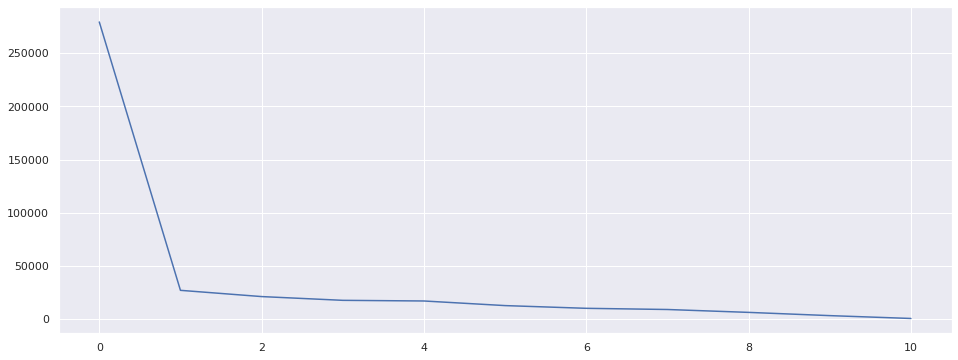

In [44]:
histogram = np.zeros(11)

for i in labels:
    histogram[i] = histogram[i] + 1
    
plt.plot(histogram)
plt.show()

In [45]:
from tensorflow.keras.utils import to_categorical

In [46]:
data_target_output = to_categorical(labels, 11)

#### GRU

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Reshape, Conv2D
from tensorflow.keras.callbacks import EarlyStopping

In [48]:
earlyStopping = EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)

In [49]:
from sklearn.model_selection import train_test_split

In [50]:
%%time
X_train, X_test, y_train, y_test = train_test_split(data_input, data_target_output, train_size=0.8)

CPU times: user 127 ms, sys: 11 ms, total: 138 ms
Wall time: 138 ms


In [51]:
model = Sequential([
    Reshape(
        input_shape=(X_train.shape[1], X_train.shape[2]), 
        target_shape=(X_train.shape[1], X_train.shape[2], 1)
    ),
    Conv2D(64, kernel_size=(3, 1), padding='same', activation='relu'),
    Reshape(target_shape=(X_train.shape[1], 64*X_train.shape[2])),
    GRU(64, activation='tanh'),
    Dense(11, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 23, 4, 1)          0         
_________________________________________________________________
conv2d (Conv2D)              (None, 23, 4, 64)         256       
_________________________________________________________________
reshape_1 (Reshape)          (None, 23, 256)           0         
_________________________________________________________________
gru (GRU)                    (None, 64)                61824     
_________________________________________________________________
dense (Dense)                (None, 11)                715       
Total params: 62,795
Trainable params: 62,795
Non-trainable params: 0
_________________________________________________________________


In [52]:
%%time
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2, callbacks=[earlyStopping])

Epoch 1/50
4014/4014 [==============================] - 17s 4ms/step - loss: 0.5100 - accuracy: 0.8120 - val_loss: 0.4411 - val_accuracy: 0.8351
Epoch 2/50
4014/4014 [==============================] - 16s 4ms/step - loss: 0.4218 - accuracy: 0.8417 - val_loss: 0.4163 - val_accuracy: 0.8382
Epoch 3/50
4014/4014 [==============================] - 16s 4ms/step - loss: 0.4003 - accuracy: 0.8473 - val_loss: 0.3952 - val_accuracy: 0.8487
Epoch 4/50
4014/4014 [==============================] - 17s 4ms/step - loss: 0.3890 - accuracy: 0.8496 - val_loss: 0.3916 - val_accuracy: 0.8492
Epoch 5/50
4014/4014 [==============================] - 16s 4ms/step - loss: 0.3814 - accuracy: 0.8516 - val_loss: 0.3835 - val_accuracy: 0.8507
Epoch 6/50
4014/4014 [==============================] - 16s 4ms/step - loss: 0.3761 - accuracy: 0.8542 - val_loss: 0.3809 - val_accuracy: 0.8513
Epoch 7/50
4014/4014 [==============================] - 16s 4ms/step - loss: 0.3717 - accuracy: 0.8555 - val_loss: 0.3772 - val_ac

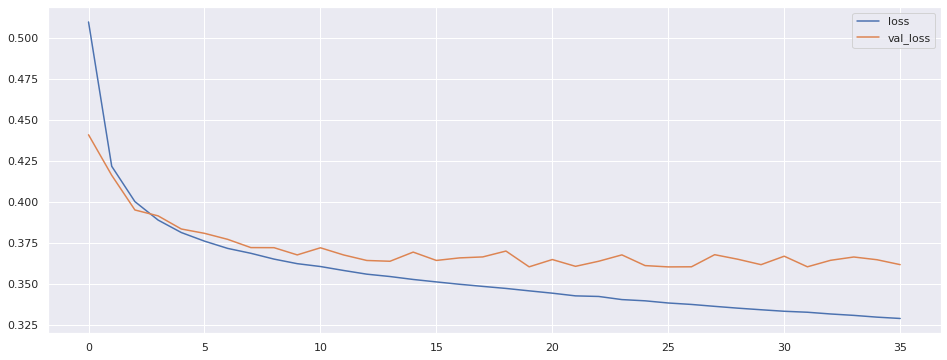

In [53]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

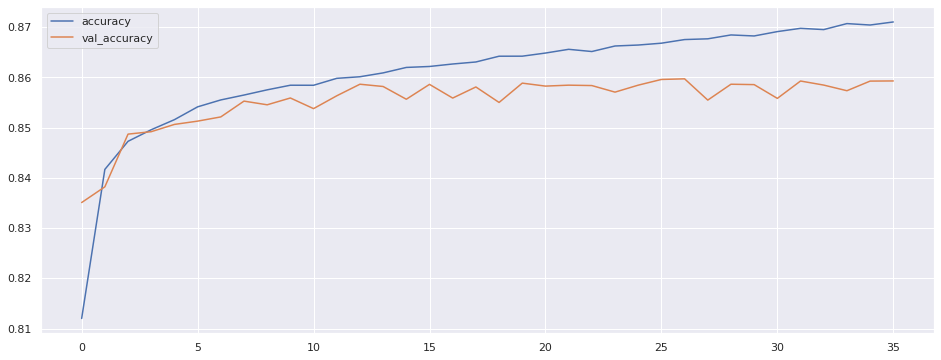

In [54]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [55]:
%%time
model.evaluate(X_test, y_test)

2509/2509 [==============================] - 6s 2ms/step - loss: 0.3508 - accuracy: 0.8623
CPU times: user 6.71 s, sys: 971 ms, total: 7.68 s
Wall time: 6.06 s


[0.35076677799224854, 0.8623219728469849]

In [56]:
y_test.shape

(80267, 11)

In [57]:
%%time
y_predicted = model.predict(X_test)

CPU times: user 3.97 s, sys: 308 ms, total: 4.27 s
Wall time: 3.36 s


In [58]:
YP = np.array([x.tolist().index(max(x)) for x in y_predicted])
YT = np.array([x.tolist().index(max(x)) for x in y_test])

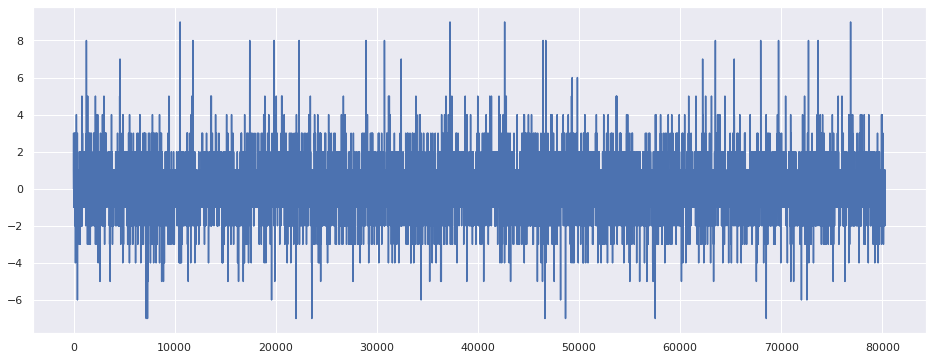

In [59]:
error = YT - YP
plt.plot(error)
plt.show()